# Stochastic SEIR model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# similar parameters to deterministic model

N = 1_000_000
sigma = 1 / 4.0
gamma = 1 / 6.0
R0 = 3.0
beta = R0 * gamma

dt = 0.5  # time step (days)
t_max = 180
steps = int(t_max / dt)

In [2]:
def stochastic_seir(seed = None):
    rng = np.random.default_rng(seed)

    S, E, I, R = N - 10, 0, 10, 0

    S_hist, E_hist, I_hist, R_hist = [], [], [], []

    for _ in range(steps):
        # Expected transitions
        lambda_SE = beta * S * I / N * dt

        # Random transitions
        new_E = rng.poisson(lambda_SE)
        new_I = rng.binomial(E, 1 - np.exp(-sigma * dt))
        new_R = rng.binomial(I, 1 - np.exp(-gamma * dt))

        # Prevent negative counts
        new_E = min(new_E, S)
        new_I = min(new_I, E)
        new_R = min(new_R, I)

        # Update compartments
        S -= new_E
        E += new_E - new_I
        I += new_I - new_R
        R += new_R

        S_hist.append(S)
        E_hist.append(E)
        I_hist.append(I)
        R_hist.append(R)

    return np.array(S_hist), np.array(E_hist), np.array(I_hist), np.array(R_hist)

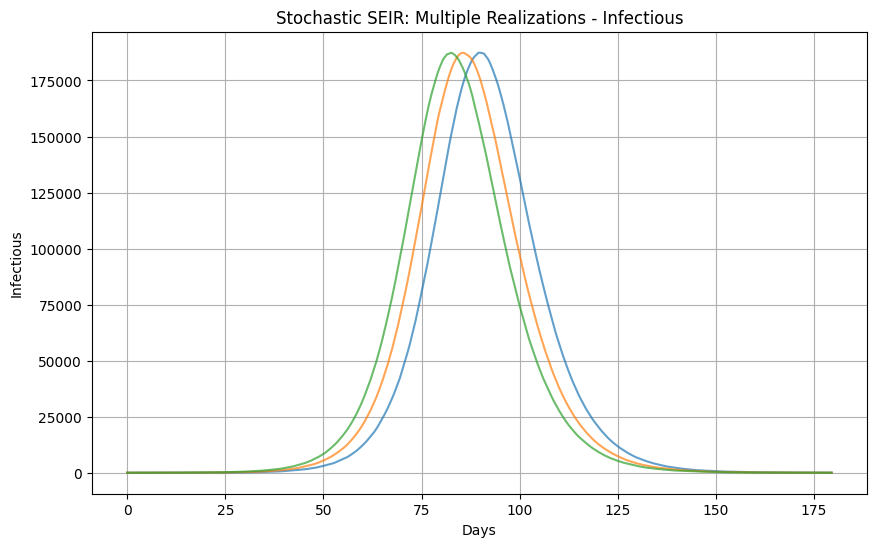

In [4]:
# plot

t = np.arange(steps) * dt

plt.figure(figsize=(10, 6))

for seed in [1, 2, 3]:
    _, _, I, _ = stochastic_seir(seed)
    plt.plot(t, I, alpha=0.7)

plt.xlabel("Days")
plt.ylabel("Infectious")
plt.title("Stochastic SEIR: Multiple Realizations - Infectious")
plt.grid(True)
plt.show()

Baseline stochastic outvcome distribution


# for each stochastic run we record
1. Total infected = N - S(final)
2. Peak Infectious load = maxI(t)
3. Time to peak = arg maxI(t)

In [5]:
n_runs = 500

total_infected = []
peak_infected = []
time_to_peak = []

for seed in range(n_runs):
    S, E, I, R = stochastic_seir(seed)

    total_infected.append(R[-1])
    peak_infected.append(I.max())
    time_to_peak.append(np.argmax(I) * dt)

In [6]:
# converting into arrays
total_infected = np.array(total_infected)
peak_infected = np.array(peak_infected)
time_to_peak = np.array(time_to_peak)

In [7]:
# summary stats
def summarize(x, name):
    print(f"{name}")
    print(f" Mean   : {x.mean():,.0f}")
    print(f" Median : {np.median(x):,.0f}")
    print(f" 5-95%  : {np.percentile(x,5):,.0f} - {np.percentile(x,95):,.0f}")
    print()

summarize(total_infected, "Total Infected")
summarize(peak_infected, "peak_infected")
summarize(time_to_peak, "time_to_peak (days)")

Total Infected
 Mean   : 951,312
 Median : 951,320
 5-95%  : 950,806 - 951,808

peak_infected
 Mean   : 187,201
 Median : 187,214
 5-95%  : 186,299 - 188,022

time_to_peak (days)
 Mean   : 84
 Median : 84
 5-95%  : 80 - 90



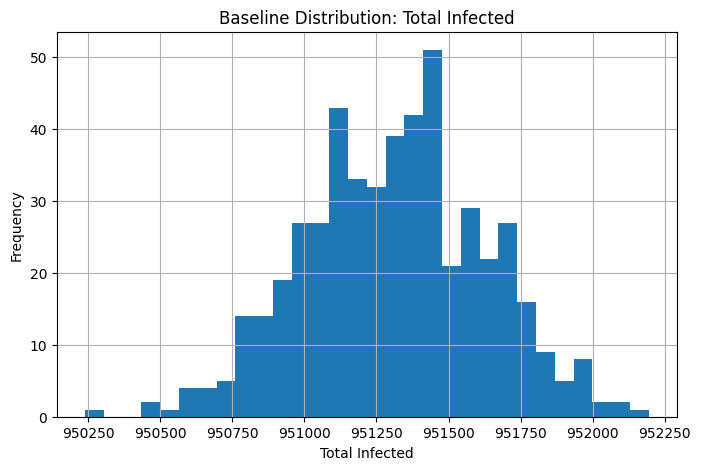

In [8]:
# Histogram: total infected
plt.figure(figsize=(8,5))
plt.hist(total_infected, bins=30)
plt.xlabel("Total Infected")
plt.ylabel("Frequency")
plt.title("Baseline Distribution: Total Infected")
plt.grid(True)
plt.show()

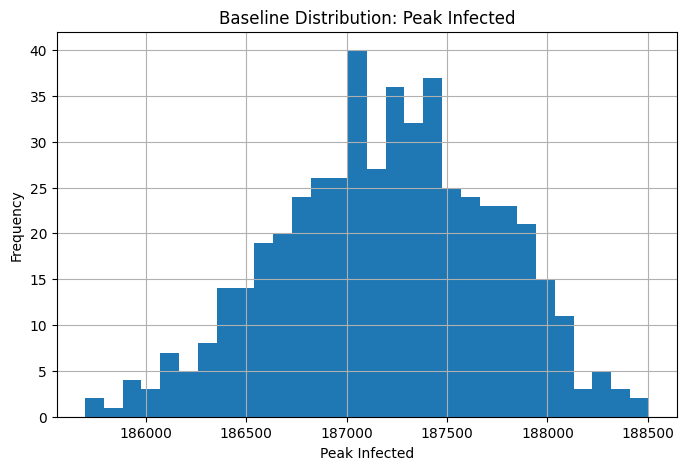

In [ ]:
# Histogram: Peak infected
plt.figure(figsize=(8,5))
plt.hist(peak_infected, bins=30)
plt.xlabel("Peak Infected")
plt.ylabel("Frequency")
plt.title("Baseline Distribution: Peak Infected")
plt.grid(True)
plt.show()

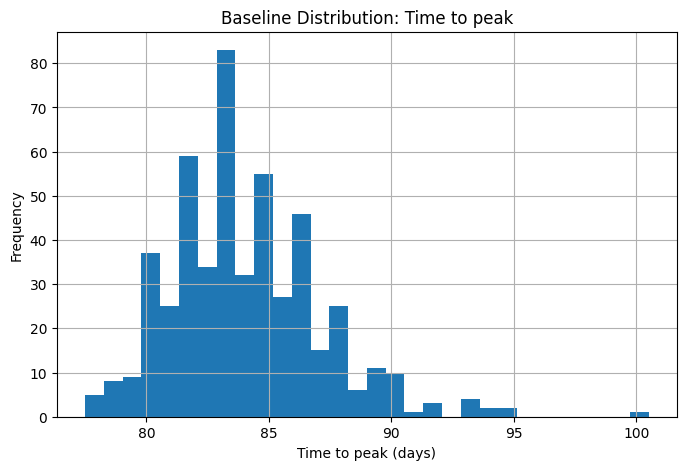

In [ ]:
# Histogram: time to peak
plt.figure(figsize=(8,5))
plt.hist(time_to_peak, bins=30)
plt.xlabel("Time to peak (days)")
plt.ylabel("Frequency")
plt.title("Baseline Distribution: Time to peak")
plt.grid(True)
plt.show()

#### now we will introduce uniform vaccination
#### every susceptible individal has equal chance of vaccination (basic). 
#### will have vaccinations start on a fixed day.
#### we will keep the no of vaccinations per day fixed. 
#### for now Vaccination -> immediate immunity.

In [17]:
def stochastic_seir_vaccinated(
        seed = None,
        vax_start_day = 60,
        daily_vax = 5000,
        max_coverage = 0.7,
        dt = 0.5,
        t_max = 180
):
    rng = np.random.default_rng(seed)

    S, E, I, R = N - 10, 0, 10, 0
    max_vaccinated = int(max_coverage * N)

    S_hist, E_hist, I_hist, R_hist = [], [], [], []

    steps = int(t_max / dt)

    for step in range(steps):
        t = step * dt

        # disease tranitions
        lambda_SE = beta * S * I / N * dt
        new_E = rng.poisson(lambda_SE)
        new_I = rng.binomial(E, 1 - np.exp(-sigma * dt))
        new_R = rng.binomial(I, 1 - np.exp(-gamma * dt))

        new_E = min(new_E, S)
        new_I = min(new_I, E)
        new_R = min(new_R, I)

        # vaccination transition
        new_V = 0
        if t >= vax_start_day and R < max_vaccinated:
            daily_capacity = daily_vax * dt
            p_vacc = min(daily_capacity / S, 1.0)
            new_V = rng.binomial(S, p_vacc)

        # update compartments
        S -= (new_E + new_V)
        E += new_E - new_I
        I += new_I - new_R
        R += new_R + new_V

        S_hist.append(S)
        E_hist.append(E)
        I_hist.append(I)
        R_hist.append(R)
    
    return (
        np.array(S_hist), 
        np.array(E_hist), 
        np.array(I_hist), 
        np.array(R_hist),
    )

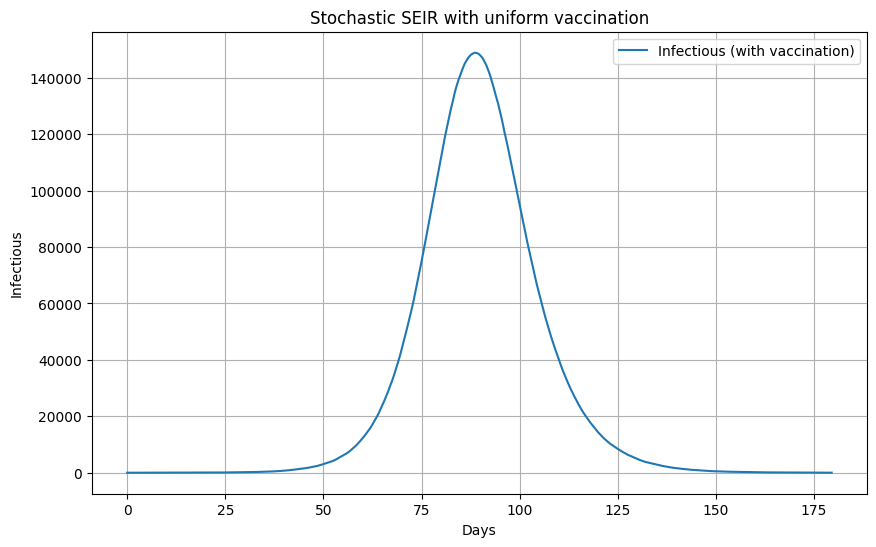

In [19]:
# sanity check
S, E, I, R = stochastic_seir_vaccinated(seed=1)

t = np.arange(len(I)) * dt

plt.figure(figsize=(10,6))
plt.plot(t, I, label="Infectious (with vaccination)")
plt.xlabel("Days")
plt.ylabel("Infectious")
plt.title("Stochastic SEIR with uniform vaccination")
plt.legend()
plt.grid(True)
plt.show()

# Batch vaccination simulations

In [20]:
n_runs = 500

vax_total_infected = []
vax_peak_infected = []
vax_time_to_peak = []

for seed in range(n_runs):
    S, E, I, R = stochastic_seir_vaccinated(seed)

    vax_total_infected.append(R[-1])
    vax_peak_infected.append(I.max())
    vax_time_to_peak.append(np.argmax(I) * 0.5)

In [22]:
vax_total_infected = np.array(vax_total_infected)
vax_peak_infected = np.array(vax_peak_infected)
vax_time_to_peak = np.array(vax_time_to_peak)

In [23]:
print("Baseline vs vaccination\n")

summarize(total_infected, "Baseline: Total Infected")
summarize(vax_total_infected, "Vaccination: Total Infected")

summarize(peak_infected, "Baseline: Peak Infected")
summarize(vax_peak_infected, "Vaccination: Peak Infected")

summarize(time_to_peak, "Baseline: Time to peak")
summarize(vax_time_to_peak, "Vaccination: Time to peak")


Baseline vs vaccination

Baseline: Total Infected
 Mean   : 951,312
 Median : 951,320
 5-95%  : 950,806 - 951,808

Vaccination: Total Infected
 Mean   : 949,489
 Median : 949,790
 5-95%  : 945,080 - 952,729

Baseline: Peak Infected
 Mean   : 187,201
 Median : 187,214
 5-95%  : 186,299 - 188,022

Vaccination: Peak Infected
 Mean   : 159,137
 Median : 160,100
 5-95%  : 149,108 - 166,813

Baseline: Time to peak
 Mean   : 84
 Median : 84
 5-95%  : 80 - 90

Vaccination: Time to peak
 Mean   : 83
 Median : 82
 5-95%  : 78 - 88



# Compute point-estimate ATE(average treatment effect)

In [24]:
# Peak infected ATE
ate_peak = np.mean(vax_peak_infected - peak_infected)
ate_peak

np.float64(-28063.624)

In [25]:
# Time to peak ATE
ate_time = np.mean(vax_time_to_peak - time_to_peak)
ate_time

np.float64(-1.329)

In [26]:
# how uncertain is the ATE?
# Bootstrap uncertainty

def bootstrap_ate(y_treat, y_control, n_boot = 2000, seed = 42):
    rng = np.random.default_rng(seed)
    n = len(y_treat)

    ates = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        ates.append(np.mean(y_treat[idx] - y_control[idx]))
    
    ates = np.array(ates)

    return {
        "ate_mean": ates.mean(),
        "ci_2.5": np.percentile(ates, 2.5),
        "ci_97.5": np.percentile(ates, 97.5),
        "ates": ates
    }

In [27]:
# bootstrap to peak infected
boot_peak = bootstrap_ate(vax_peak_infected, peak_infected)

boot_peak

{'ate_mean': np.float64(-28062.908729000002),
 'ci_2.5': np.float64(-28551.503099999998),
 'ci_97.5': np.float64(-27584.67745),
 'ates': array([-27755.602, -28434.008, -28170.526, ..., -27944.582, -27888.41 ,
        -28302.86 ], shape=(2000,))}

In [28]:
# bootstrap to time to peak
boot_time = bootstrap_ate(vax_time_to_peak, time_to_peak)

boot_time

{'ate_mean': np.float64(-1.3285019999999998),
 'ci_2.5': np.float64(-1.363),
 'ci_97.5': np.float64(-1.294),
 'ates': array([-1.338, -1.287, -1.323, ..., -1.345, -1.314, -1.334], shape=(2000,))}

# Adding deaths with Single IFR(infection fatality rate)

In [37]:
def stochastic_seir_vaccinated_with_deaths(
        seed = None,
        vax_start_day = 60,
        daily_vax = 5000,
        max_coverage = 0.7,
        dt = 0.5,
        t_max = 180,
        IFR = 0.008
):
    rng = np.random.default_rng(seed)

    S, E, I, R = N - 10, 0, 10, 0
    D = 0 # cumulative deaths

    max_vaccinated = int(max_coverage * N)
    steps = int(t_max / dt)

    S_hist, E_hist, I_hist, R_hist, D_hist = [], [], [], [], []

    for step in range(steps):
        t = step * dt

        # Disease transitions
        lambda_SE = beta * S * I / N * dt
        new_E = rng.poisson(lambda_SE)
        new_I = rng.binomial(E, 1-np.exp(-sigma * dt))
        new_R = rng.binomial(I, 1-np.exp(-gamma * dt))

        new_E = min(new_E, S)
        new_I = min(new_I, E)
        new_R = min(new_R, I)

        # vaccination
        new_V = 0
        if t >= vax_start_day and R < max_vaccinated and S > 0:
            daily_capacity = daily_vax * dt
            p_vacc = min(daily_capacity / S, 1.0)
            new_V = rng.binomial(S, p_vacc)

        # deaths 
        new_D = rng.binomial(new_R, IFR)

        # updating compartments
        S -= (new_E + new_V)
        E += new_E - new_I
        I += new_I - new_R
        R += new_R + new_V
        D += new_D

        S_hist.append(S)
        E_hist.append(E)
        I_hist.append(I)
        R_hist.append(R)
        D_hist.append(D)
    
    return (
        np.array(S_hist),
        np.array(E_hist),
        np.array(I_hist),
        np.array(R_hist),
        np.array(D_hist),
    )

In [38]:
S, E, I, R, D = stochastic_seir_vaccinated_with_deaths(seed = 1)
print("Total deaths:", D[-1])

Total deaths: 6251


# batch simulations baseline vs vaccination

In [ ]:
# vaccine deaths
n_runs = 500

vax_deaths = []

for seed in range(n_runs):
    _, _, _, _, D = stochastic_seir_vaccinated_with_deaths(seed)
    vax_deaths.append(D[-1])

vax_deaths = np.array(vax_deaths)

In [40]:
# baseline deaths
baseline_deaths = []

for seed in range(n_runs):
    _, _, _, _, D = stochastic_seir_vaccinated_with_deaths(
        seed=seed,
        daily_vax= 0
    )
    baseline_deaths.append(D[-1])

baseline_deaths = np.array(baseline_deaths)

In [41]:
summarize(baseline_deaths, "Baseline: Total Deaths")
summarize(vax_deaths, "vaccination: Total Deaths")

Baseline: Total Deaths
 Mean   : 7,609
 Median : 7,608
 5-95%  : 7,469 - 7,749

vaccination: Total Deaths
 Mean   : 6,364
 Median : 6,378
 5-95%  : 6,083 - 6,608



In [ ]:
# causal effect on deaths
boot_deaths = bootstrap_ate(vax_deaths, baseline_deaths)
boot_deaths

{'ate_mean': np.float64(-1244.911339),
 'ci_2.5': np.float64(-1259.953),
 'ci_97.5': np.float64(-1229.36265),
 'ates': array([-1243.87 , -1243.602, -1251.844, ..., -1248.056, -1238.68 ,
        -1252.658], shape=(2000,))}

: 